In [1]:
# imports
import sys
import pandas as pd
import numpy as np
import pickle
import time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

#from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG=True
#from rdkit import DataStructs

from pandarallel import pandarallel
from tqdm import tqdm

from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec, mol2sentence
from mol2vec.helpers import depict_identifier, mol_to_svg, IdentifierTable, plot_2D_vectors
from scipy.stats import hypergeom
import collections
import re
pandarallel.initialize(progress_bar = True,nb_workers=16)
tqdm.pandas()
import json
import umap
import umap.plot
from scipy.spatial.distance import pdist, squareform
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import joblib
from IPython.core.display import HTML
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
PandasTools.RenderImagesInAllDataFrames(images=True)
from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles
import matplotlib
import itertools
from itertools import compress
from statsmodels.stats.multitest import fdrcorrection
import pubchempy as pcp
from bioservices import *
from sklearn.decomposition import PCA
from sklearn import datasets
import math

from scipy.stats import entropy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp


matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15

unable to import 'smart_open.gcs', disabling that module


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/giulia/anaconda/lib/python3.6/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


# Load the Data
Data from January from Michael + Genomics annotations from Shany

In [4]:
# load file into a dataframe
df=pd.read_csv('plant_masterTable_Mol2vec_092721_ndup.csv')
df

compound          fblock  \
0      OFNSUWBAQRCHAV-SPHDKFQHSA-N  OFNSUWBAQRCHAV   
1      DLRVVLDZNNYCBX-NNDSTVLFSA-N  DLRVVLDZNNYCBX   
2      WLFXSECCHULRRO-UHFFFAOYSA-N  WLFXSECCHULRRO   
3      KUSXXCNWFFLERW-ORIPQNMZSA-N  KUSXXCNWFFLERW   
4      LWROVTMVBSWNIL-ZZXKWVIFSA-N  LWROVTMVBSWNIL   
...                            ...             ...   
14815  ATYJTMHKKALSMT-BLQZNRGMSA-N  ATYJTMHKKALSMT   
14816  OKHXOUGRECCASI-SHUUEZRQSA-J  OKHXOUGRECCASI   
14817  DKHPMPVMENETGL-HNNISBQLSA-N  DKHPMPVMENETGL   
14818  GRQWEXRTFAUFIC-SVNQLWEDSA-N  GRQWEXRTFAUFIC   
14819  GFFGJBXGBJISGV-UHFFFAOYSA-N  GFFGJBXGBJISGV   

                                                  smiles  vitis vinifera_kegg  \
0      CC1=C(C(CC(C1)O)(C)C)/C=C/C(=C/C=C/C(=C\C=C\C=...                    0   
1      C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)OC[C@@H]...                    1   
2                                      C1=CC(=O)NC(=C1)O                    0   
3      CCCCCCCCCCCCCCCCCCCCCCC(=O)NC(CO)C(C(CCC/C=C/C...                    0   
4         C1=CC(=CC=C1/C=C/C(=O)C(C(C(=O)O)O)(C(=O)O)O)O                    0   
...                                                  ...                  ...   
14815  CC[C@H](/C=C/[C@@H](C)[C@H]1CCC2C3=CC[C@H]4C[C...                    0   
14816  C([C@H]([C@H]([C@H]([C@@H](C(=O)COP(=O)([O-])[...                    0   
14817  CC1=CC(CC(C1/C=C/C(=C/C=C/C(=C/C=C/C=C(\C)/C=C...                    0   
14818  CCCCCCCCCCCCCCCC(=O)OC(COC1C(C(C(C(O1)C(=O)O)O...                    0   
14819                               C1=NC2=NC=NC(=C2N1)N                    1   

       vitis vinifera_pmn  vitis vinifera_foodb  vitis vinifera_foodb_db  \
0                       0                     0                        0   
1                       0                     0                        0   
2                       0                     0                        0   
3                       0                     0                        0   
4                       0                     1                        1   
...                   ...                   ...                      ...   
14815                   0                     0                        0   
14816                   1                     0                        0   
14817                   0                     0                        0   
14818                   0                     0                        0   
14819                   1                     1                        1   

       vitis vinifera_usda  vitis vinifera_foodb_exp  vitis vinifera_dfc  ...  \
0                        0                         0                   0  ...   
1                        0                         0                   0  ...   
2                        0                         0                   0  ...   
3                        0                         0                   0  ...   
4                        0                         0                   0  ...   
...                    ...                       ...                 ...  ...   
14815                    0                         0                   0  ...   
14816                    0                         0                   0  ...   
14817                    0                         0                   0  ...   
14818                    0                         0                   0  ...   
14819                    0                         0                   0  ...   

       asparagus officinalis_pmn  asparagus officinalis_foodb  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   
...                          ...                          ...   
14815                          0                            0  

In [5]:
df.shape

(14820, 781)

In [9]:
# string of the embedding
len(df.loc[0, 'Mol2vec'])

3957

# Functions to Covert Full InChi into First Block
'totonlyexpri' is the variable measuring the total number of compounds in plants for which we have experiments, including all the databases, genomics.

How much would this change if we include all plants?

In [10]:
def convert2fb(iklist):
    """ converts a full key list to first block list"""
    fblist=set()
    for ik in iklist:
        ikl=ik.split('-')
        if ikl[0].startswith('XXFWWUCLFPRWQI'):
            pass
        fblist.add(ikl[0])
        fb2ik[ikl[0]]=ik
    return fblist

fb2ik={}
# work on the plants we have experiments for
orgs=pickle.load(open('orgkeys_new.pkl','rb'))
totonlyexpri=set()
plantlist=set()
totexp=set()
# get big M for the overlaps with experiments
for org in orgs:
    if 'experiment' in orgs[org]:
        plantlist.add(org)
        for atr in orgs[org]:
            if atr in orgs[org]:
                totonlyexpri = totonlyexpri | orgs[org][atr]
                if 'experiment' in atr:
                    totexp=totexp|orgs[org][atr]



totonlyexpri=convert2fb(totonlyexpri)
len(totonlyexpri)

7562

# PCA on Mol2Vec embedding
matrix for PCA is 300 x 7,562 
Normalization over the columns
Upper bound on the number of non zero eigenvalues: 300

In [11]:
def pcaMtxPrep(fbset):
    """prepares the input matrix for PCA.
     fb+ embeddings dimesion and the calculate the z scores for the matrix"""
    newdf=pd.DataFrame()
    fbsetl=list(fbset)
    empty_rows=set()
    cleanset=set()
    for k in tqdm(fbsetl):
        if any(x in k for x in ['QBLSEPRESQJTCI','QNAUHHROLOGFEY','OMAOKVYASDIYQG',
                                'ZIHHMGTYZOSFRC','VIJMEYIOPTVQKA']):

            continue
        cleanset.add(k)
        row=df[df['fblock']==k]

        # get the embeddings and break into columns
        embd=row['Mol2vec']
        for dim in embd:
            newrow=[]
            dim=dim.replace('\n','').replace('  ',' ')
            diml=dim.split(' ')
            for i,d in enumerate(diml):
                d=d.replace('[','').replace(']','')
                if d:
                    d=float(d.strip())
                    title='dim_'+str(i)
                    newrow.append(d)
        if newrow:
            # add the row as a column to the array with the header of the first block
            '''row_to_add = pd.Series(newrow, name=k)
            newdf = newdf.append(row_to_add)'''
            newdf[k]=newrow
        else:
            empty_rows.add(k)
    return newdf, cleanset

def calcPCA(df,ikset):
    """ normalizing the matrix by calculating the z-scores of the each embedding column
    Then the z-score matrix is used as input for the PCA function
    Finally the eigenvales are aquired for further use in the hypergeometric test"""

    # step 1 - calculate the z- score for each column in the matrix
    # transpose the dataframe to calculate z-score for the compounds and not for the embeddingsd
    check_nan_in_df = df.isnull().values.any()
    '''print (check_nan_in_df)
    test1=np.where(np.isnan(df))
    ds = df.isin([np.inf, -np.inf])
    print(ds)
    pca = PCA()

    pca.fit_transform(df)'''
    cols=list(df.columns)
    zsdf=pd.DataFrame()
    for i,col in tqdm(enumerate(cols)):
        ztest=(df[col] - df[col].mean())/df[col].std()
        if any(ztest.isna()):
            print(str(ztest)+' is nan')
        if any(ztest.isin([np.inf, -np.inf])):
            print(str(ztest)+' is inf')
        zsdf[i]=(df[col] - df[col].mean())/df[col].std()

    zsdf

    # PCA it
    pca = PCA()

    pca.fit_transform(zsdf)
    # divide the eigenvalues by the sum of the number of compounds   (counter)
    deig=[]
    esum=0
    jsum=0
    effective_num=0 #pca.components_.shape[0]
    Ncomp=pca.components_.shape[0] #len(ikset)
    # check with a thrshold related to the number of the feautures as they are less
    avg = 1 / (len(ikset))
    sd = math.sqrt(((avg * (1 - avg)) / (len(ikset) + 1)))
    sd1=math.sqrt(((Ncomp-1)/(Ncomp+1))*(1/Ncomp**2))
    test = pca.explained_variance_ratio_
    for i,eig in enumerate(pca.explained_variance_ratio_):
        esum+=eig
        # james correction
        jsum+=(eig-1)**2
        deigt=eig/esum
        if deigt > avg:
            effective_num+=1
        deig.append(deigt)

    '''jvar=jsum/(Ncomp-1)
    # james M effective
    effective_num=round(Ncomp*(1-(Ncomp-1)*(jvar/Ncomp**2)),0)'''
    print('effective num: '+ str(effective_num))
    return deig[:15], effective_num, zsdf

# big M
bigMdf,netmset=pcaMtxPrep(totonlyexpri)
Mvecs,nbigm=calcPCA(bigMdf,netmset)

Mvecs
nbigm

100%|██████████| 7562/7562 [00:16<00:00, 460.78it/s]
7561it [00:13, 552.01it/s]


effective num: 71


71

In [146]:
bigMdf.to_csv('bigMdf.csv')

In [46]:
corrmat=bigMdf.corr()

In [51]:
corrmat2=corrmat.values.copy()
np.fill_diagonal(corrmat2,0)

Text(0, 0.5, 'PDF')

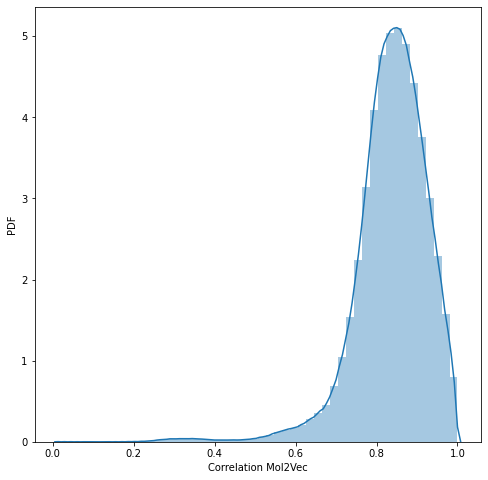

In [56]:
corrmat2=squareform(corrmat2)
plt.figure(figsize = (8, 8))
sns.distplot(corrmat2)
plt.xlabel('Correlation Mol2Vec')
plt.ylabel('PDF')

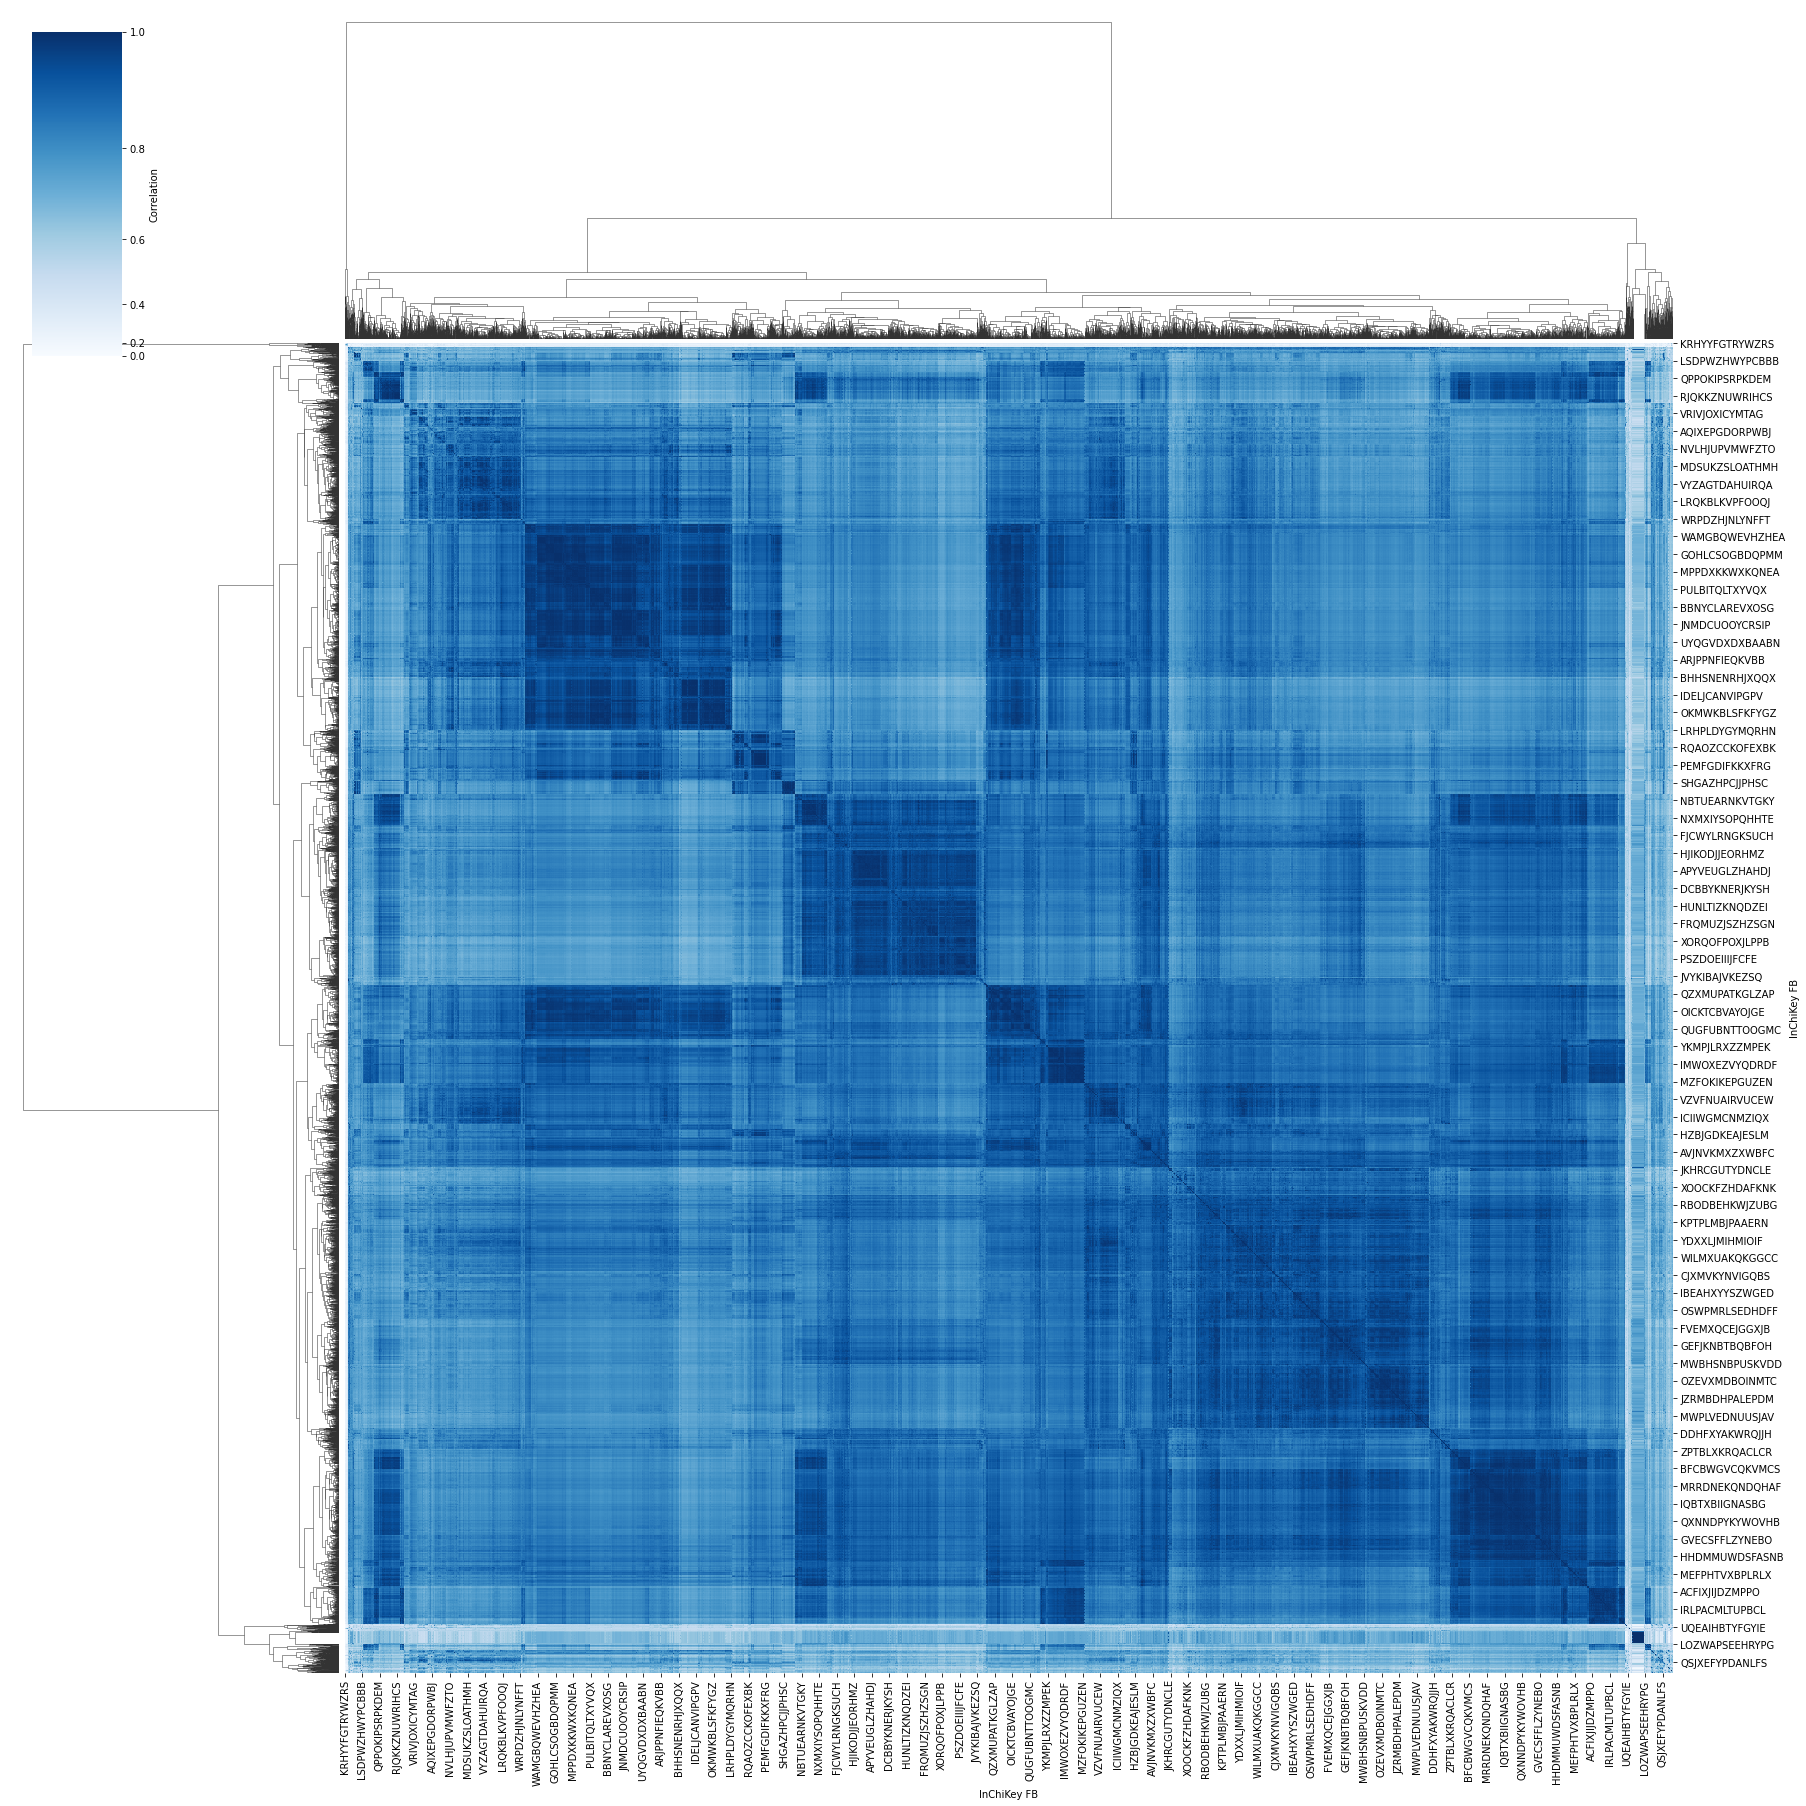

In [60]:
g = sns.clustermap(corrmat,cmap="Blues",vmin=0, vmax=1,figsize=(25,25), cbar_kws={'label': 'Correlation'},xticklabels = 100, yticklabels = 100,
                  norm=colors.PowerNorm(gamma=2))
ax = g.ax_heatmap
ax.set_xlabel('InChiKey FB');
ax.set_ylabel('InChiKey FB');

To access the reordered row indices, use: g.dendrogram_row.reordered_ind

Column indices, use: g.dendrogram_col.reordered_ind

The linkage matrix, the input used to compute the dendrogram is at:

g.dendrogram_col.linkage
g.dendrogram_row.linkage

In [73]:
from scipy.spatial.distance import pdist, squareform
from dynamicTreeCut import cutreeHybrid
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

In [74]:
linkage_mat=g.dendrogram_col.linkage
distances = pdist(corrmat, 'euclidean')

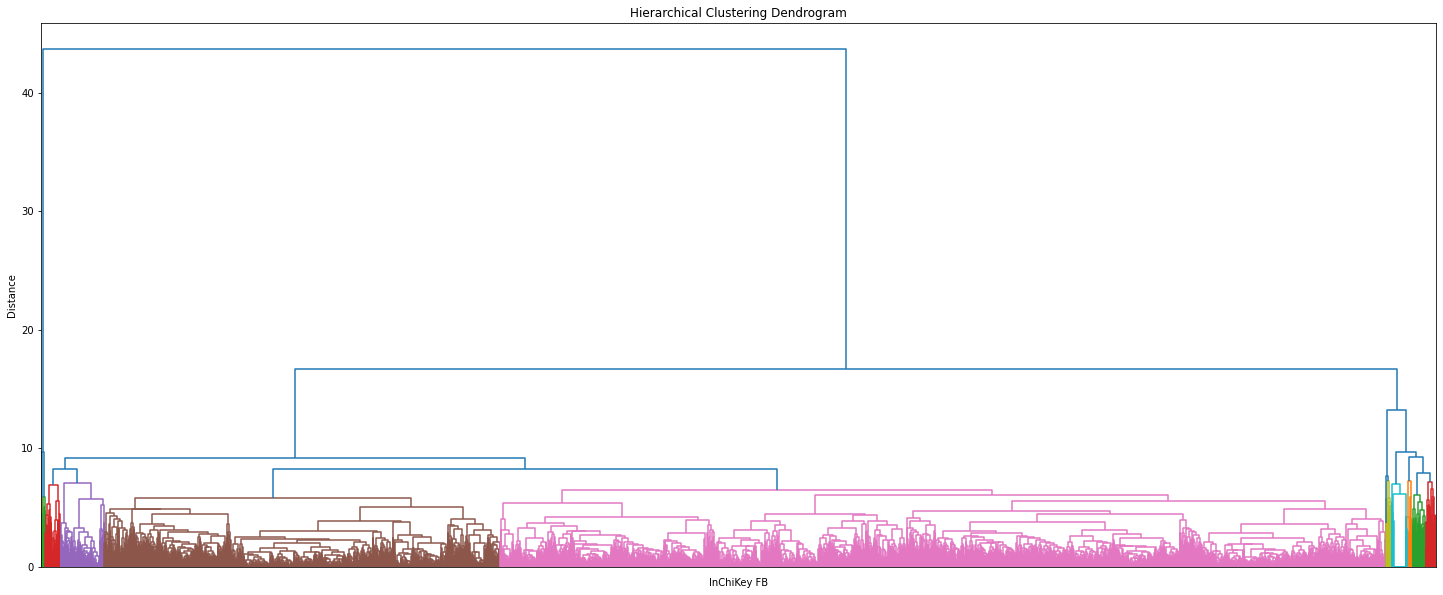

In [83]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('InChiKey FB')
plt.ylabel('Distance')
d=dendrogram(
    linkage_mat,
    #leaf_rotation=90.,  # rotates the x axis labels
    #leaf_font_size=5.,  # font size for the x axis labels
    #labels=corrmat.index,
    labels=['']*len(corrmat.index),
    color_threshold=7.5
);

In [76]:
# cophenet distance
c, coph_dists = cophenet(linkage_mat, distances)
c

0.8946456694739154

In [193]:
maxd=7.5
clustervec=fcluster(linkage_mat, maxd, criterion='distance')
print("Number of clusters: {} ".format(len(set(clustervec))))

Number of clusters: 12 


In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Pipeline with a scaler and PCA 
pipeALL = Pipeline([('scaler', StandardScaler()), ('reducer', PCA())])
# Fit the pipe to the data
pipeALL.fit(bigMdf)

Pipeline(steps=[('scaler', StandardScaler()), ('reducer', PCA())])

Number of Components greater than 1/(Num Chemicals)
71


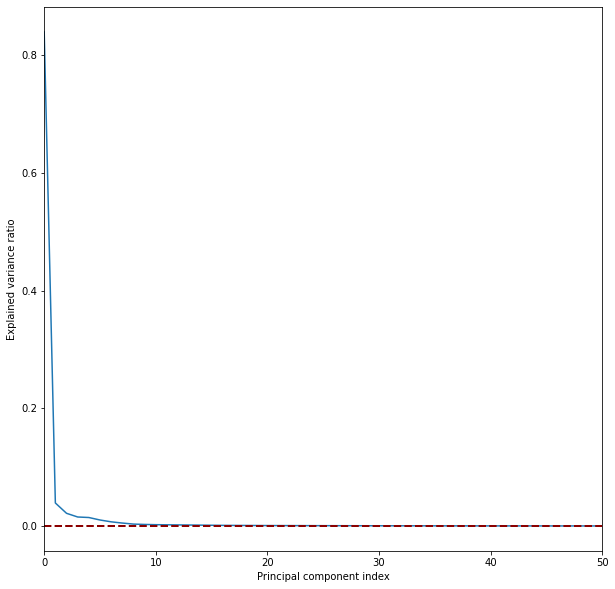

In [187]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(pipeALL.steps[1][1].explained_variance_ratio_)
plt.axhline(1/bigMdf.shape[1], color='darkred', linestyle='dashed', linewidth=2)
#plt.axhline(1/bigMdf.shape[0], color='k', linestyle='dashed', linewidth=2)
print('Number of Components greater than 1/(Num Chemicals)')
print(sum(pipeALL.steps[1][1].explained_variance_ratio_>1/bigMdf.shape[1]))
#print('Number of Components greater than 1/(Num Mol2vec Dim)')
#print(sum(pipeALL.steps[1][1].explained_variance_ratio_>1/bigMdf.shape[0]))

plt.xlim([0, 50])
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio');

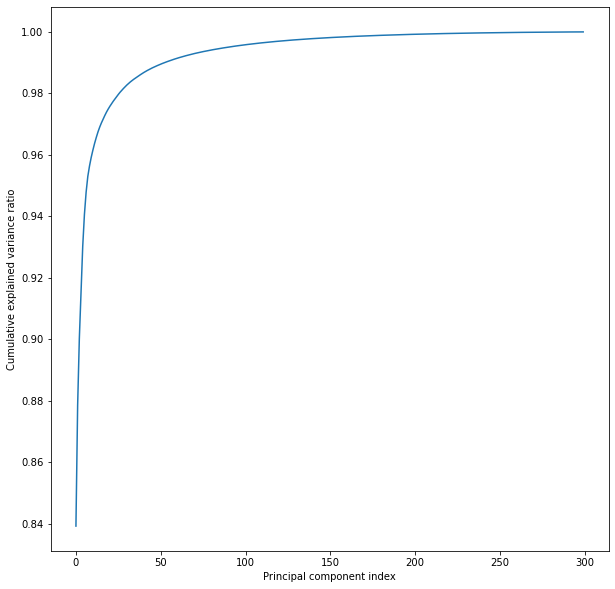

In [99]:
plt.figure(figsize=(10, 10))
plt.plot(pipeALL.steps[1][1].explained_variance_ratio_.cumsum())
plt.xlabel('Principal component index')
plt.ylabel('Cumulative explained variance ratio');

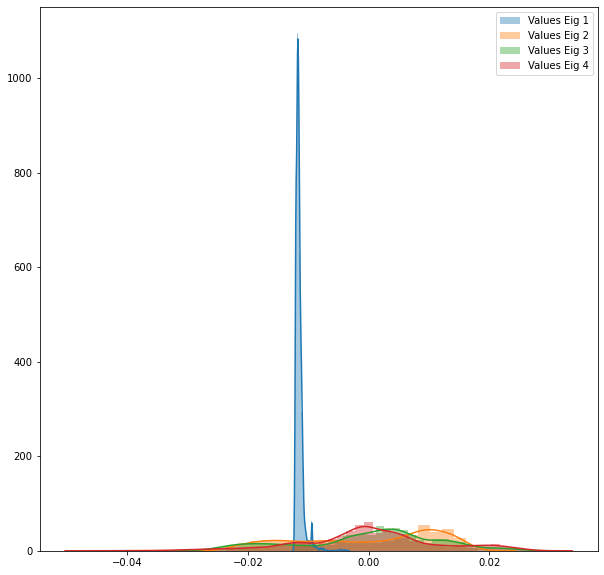

In [121]:
plt.figure(figsize=(10, 10))
numcomp=4
for ind in range(numcomp):
    sns.distplot(pipeALL.steps[1][1].components_[ind], label='Values Eig '+str(ind+1))

plt.legend();

In [101]:
from scipy.stats import entropy
print('Intrinsic Dimension')
print(np.exp(entropy(pipeALL.steps[1][1].explained_variance_ratio_)))

Intrinsic Dimension
2.561253932940762


# Clean Correlation Matrix Removing Dominant Eigenvector

In [148]:
w, v = np.linalg.eig(corrmat)

In [173]:
# check
#w[0].real
#sum(w).real
#sum(w.real[0:300])

In [174]:
w=w.real
v=v.real

In [175]:
filtermat=corrmat.values - w[0]*np.outer(v[:,0], v[:,0])

In [181]:
vnonz=np.triu(filtermat)[np.triu(filtermat)!=0]

Text(0, 0.5, 'PDF')

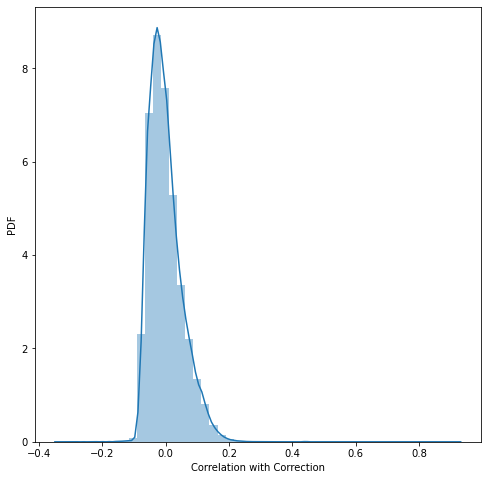

In [182]:
plt.figure(figsize = (8, 8))
sns.distplot(vnonz)
plt.xlabel('Correlation with Correction')
plt.ylabel('PDF')

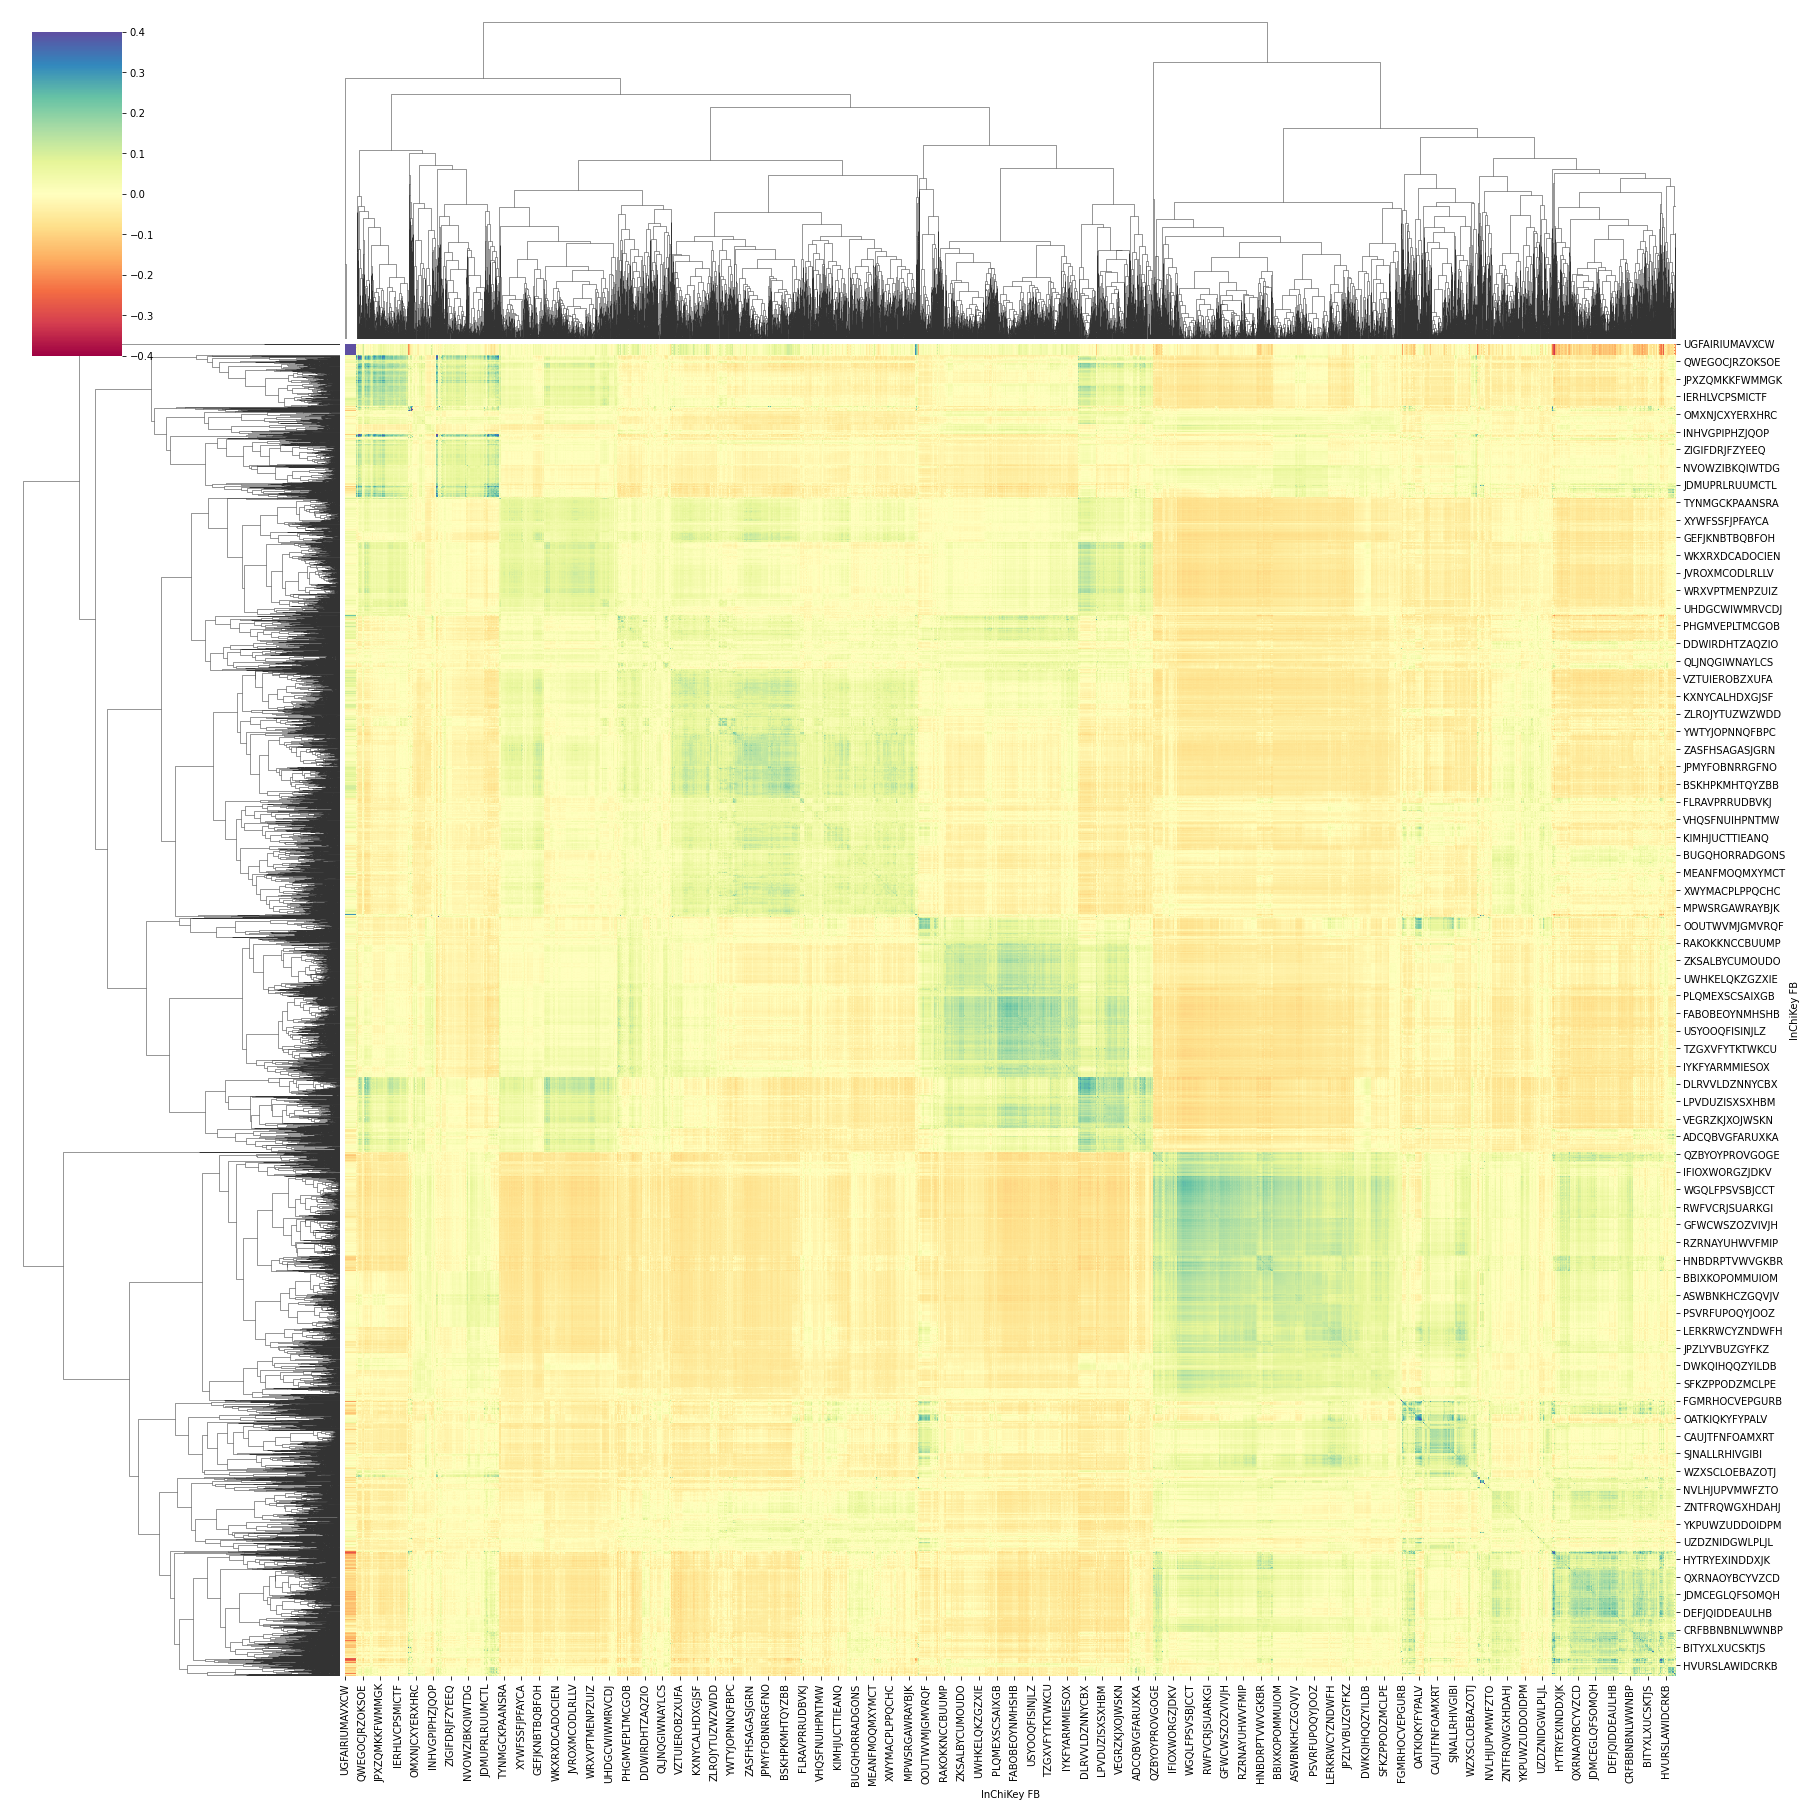

In [185]:
dfplot=pd.DataFrame(filtermat, index=corrmat.index, columns=corrmat.index)
g1 = sns.clustermap(dfplot,cmap="Spectral",vmin=-0.4, vmax=0.4,figsize=(25,25),xticklabels = 100, yticklabels = 100)
ax1 = g1.ax_heatmap
ax1.set_xlabel('InChiKey FB');
ax1.set_ylabel('InChiKey FB');

In [188]:
linkage_matF=g1.dendrogram_col.linkage
distancesF = pdist(filtermat, 'euclidean')

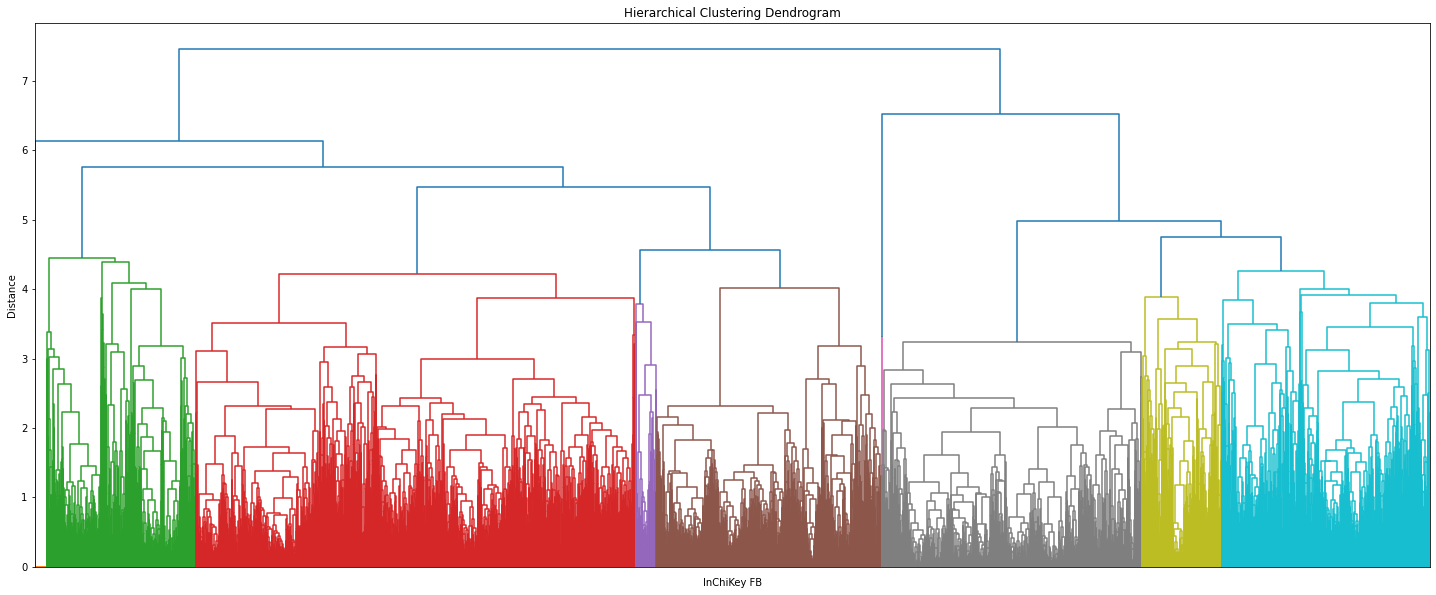

In [195]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('InChiKey FB')
plt.ylabel('Distance')
d=dendrogram(
    linkage_matF,
    #leaf_rotation=90.,  # rotates the x axis labels
    #leaf_font_size=5.,  # font size for the x axis labels
    #labels=corrmat.index,
    labels=['']*len(dfplot.index),
    color_threshold=4.5
);

In [190]:
# cophenet distance
cF, coph_distsF = cophenet(linkage_matF, distancesF)
cF

0.7343281994065308

In [194]:
maxdF=4.5
clustervecF=fcluster(linkage_matF, maxdF, criterion='distance')
print("Number of clusters: {} ".format(len(set(clustervecF))))

Number of clusters: 9 


# Export Clustering Data

In [197]:
dfcluster=pd.DataFrame.from_dict({'InchiFB':corrmat.index, 'Cluster1': clustervec, 'Cluster2': clustervecF})
dfcluster

InchiFB  Cluster1  Cluster2
0     PAZSROGSZMWHFZ         5         7
1     NASUDDVEKFXWQL         6         4
2     HEQOJEGTZCTHCF         6         3
3     ZIIUUSVHCHPIQD         6         3
4     NTYJJOPFIAHURM         6         9
...              ...       ...       ...
7556  NNNSKJSUQWKSAM         9         3
7557  YONCDTJKIZDSKQ         5         7
7558  HBTHUBMUAHAWBC         6         5
7559  SKCKOFZKJLZSFA         5         9
7560  RVIXKDRPFPUUOO        12         9

[7561 rows x 3 columns]

In [200]:
dfcluster.to_csv('clusterlabelsALLDB.csv')

In [198]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score

In [199]:
print(adjusted_mutual_info_score(dfcluster['Cluster1'],dfcluster['Cluster2'] ))
print(normalized_mutual_info_score(dfcluster['Cluster1'],dfcluster['Cluster2'] ))

0.3559010025985057
0.35833967329229804


# New Analysis on Intrinsic Dimension

In [2]:
# load file into a dataframe
df1=pd.read_csv('./datasets/plant_masterTable_100621_ds1.csv')
df2=pd.read_csv('./datasets/embedding_pg_ds2.csv')
df1.rename(columns={'Unnamed: 0': "Data_Type"}, inplace=True)
df1.set_index("Data_Type",inplace=True)
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

/Users/giulia/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [3]:
df1

ORAJWSYKRGVTDP-UHFFFAOYSA-N  \
Data_Type                                                      
compound                         ORAJWSYKRGVTDP-UHFFFAOYSA-N   
fblock                                        ORAJWSYKRGVTDP   
smiles                             COC1=C(C=CC(=C1)C=CCO)[O]   
vitis vinifera_kegg                                        0   
vitis vinifera_pmn                                         1   
...                                                      ...   
asparagus officinalis_foodb_exp                            0   
asparagus officinalis_dfc                                  0   
asparagus officinalis_total                                1   
asparagus officinalis_genomics                             1   
asparagus officinalis_kinetics                             1   

                                                       IPMYMEWFZKHGAX-UHFFFAOYSA-N  \
Data_Type                                                                            
compound                                               IPMYMEWFZKHGAX-UHFFFAOYSA-N   
fblock                                                              IPMYMEWFZKHGAX   
smiles                           C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=O)C(=C4C(=C3)...   
vitis vinifera_kegg                                                              0   
vitis vinifera_pmn                                                               0   
...                                                                            ...   
asparagus officinalis_foodb_exp                                                  0   
asparagus officinalis_dfc                                                        0   
asparagus officinalis_total                                                      0   
asparagus officinalis_genomics                                                   0   
asparagus officinalis_kinetics                                                   0   

                                                       KIENGQUGHPTFGC-SZSCBOSDSA-K  \
Data_Type                                                                            
compound                                               KIENGQUGHPTFGC-SZSCBOSDSA-K   
fblock                                                              KIENGQUGHPTFGC   
smiles                           C([C@@H](C1C(=C(C(=O)O1)[O-])O)O)OP(=O)([O-])[O-]   
vitis vinifera_kegg                                                              0   
vitis vinifera_pmn                                                               0   
...                                                                            ...   
asparagus officinalis_foodb_exp                                                  0   
asparagus officinalis_dfc                                                        0   
asparagus officinalis_total                                                      0   
asparagus officinalis_genomics                                                   0   
asparagus officinalis_kinetics                                                   0   

                                                       YNAFMBLTFSPCAE-RVJKEIMSSA-O  \
Data_Type                                                                            
compound                                               YNAFMBLTFSPCAE-RVJKEIMSSA-O   
fblock                                                              YNAFMBLTFSPCAE   
smiles                           CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...   
vitis vinifera_kegg                                                              0   
vitis vinifera_pmn                                                               0   
...                                                                            ...   
asparagus officinalis_foodb_exp                                                  0   
asparagus officinalis_dfc                                                        0   
asparagus officinalis_total                                                      0   
asparagus offici

In [21]:
df1FB

AAAFZMYJJHWUPN  AADKVFOTPQGHIF  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                         True           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total                True           False   
asparagus officinalis_genomics             True           False   
asparagus officinalis_kinetics             True           False   

                                 AADLTHQNYQJHQV  AAIXZDBTEWDLSG  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False           False   
asparagus officinalis_genomics            False           False   
asparagus officinalis_kinetics            False           False   

                                 AAJIHHYEPHRIET  AAJODOMQIUQTFG  \
Data_Type                                                         
vitis vinifera_kegg                       False            True   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False            True   
asparagus officinalis_genomics            False            True   
asparagus officinalis_kinetics            False           False   

                                 AAOPKIFUFWCDQZ  AAOVKJBEBIDNHE  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False           False   
asparagus officinalis_genomics            False           False   
asparagus officinalis_kinetics            False           False   

                                 AAOWDCXVOOKARC  AASAENAURCLYSI  ...  \
Data_Type                                                        ...   
vitis vinifera_kegg                       False           False  ...   
vitis vinifera_pmn                        False           False  ...   
vitis vinifera_foodb                      False           False  ...   
vitis vinifera_foodb_db                   False           False  ...   
vitis vinifera_usda                       False           False  ...   
...                                      

In [4]:
sorted_fb=sorted(list(set(df1.loc['fblock'])))
print(len(sorted_fb))
fb2full={fb: [fbf for fbf in df1.columns if fb in fbf] for fb in sorted_fb}

# populate the plant db
df1FB=pd.DataFrame()
for fb in sorted_fb:
    df1FB[fb]=(df1.loc['vitis vinifera_kegg':'asparagus officinalis_kinetics', fb2full[fb]].sum(axis=1)>0)    

# associated embedding
df2.columns=[c.split('-')[0] for c in df2.columns]
df2 = df2.loc[:,~df2.columns.duplicated()]
df2=df2[sorted_fb]

12662


In [16]:
plants=set([w.split('_')[0] for w in df1FB.index])
plants_w_experiments=[w.split('_')[0] for w in df1FB.index if '_experiment' in w]
plants_w_genomics=[w.split('_')[0] for w in df1FB.index if '_genomics' in w]
plants_w_kinetics=[w.split('_')[0] for w in df1FB.index if '_kinetics' in w]

# which type of annotations do we have?
annotations=set([w.split('_')[1] for w in df1FB.index])
traditionaldb=['dfc','_foodb_db','usda']
plants_w_dbs=list(set([w.split('_')[0] for w in df1FB.index if (('_dfc' in w)|('_foodb_db' in w)|('_usda' in w))]))
plants_w_dbs_index=[w for w in df1FB.index if (('_dfc' in w)|('_foodb_db' in w)|('_usda' in w))]

In [17]:
plants_w_dbs_index

['vitis vinifera_foodb_db',
 'vitis vinifera_usda',
 'vitis vinifera_dfc',
 'oryza glaberrima_foodb_db',
 'oryza glaberrima_usda',
 'oryza glaberrima_dfc',
 'phoenix dactylifera_foodb_db',
 'phoenix dactylifera_usda',
 'phoenix dactylifera_dfc',
 'cucurbita pepo subsp. pepo_dfc',
 'cucurbita pepo subsp. pepo_foodb_db',
 'cucurbita pepo subsp. pepo_usda',
 'brassica napus_foodb_db',
 'brassica napus_usda',
 'brassica napus_dfc',
 'phaseolus vulgaris_foodb_db',
 'phaseolus vulgaris_usda',
 'phaseolus vulgaris_dfc',
 'oryza longistaminata_foodb_db',
 'oryza longistaminata_usda',
 'oryza longistaminata_dfc',
 'chenopodium quinoa_foodb_db',
 'chenopodium quinoa_usda',
 'chenopodium quinoa_dfc',
 'camellia sinensis_foodb_db',
 'camellia sinensis_usda',
 'camellia sinensis_dfc',
 'vigna unguiculata_foodb_db',
 'vigna unguiculata_usda',
 'vigna unguiculata_dfc',
 'manihot esculenta_foodb_db',
 'manihot esculenta_usda',
 'manihot esculenta_dfc',
 'camelina sativa_dfc',
 'camelina sativa_usda',


In [5]:
df1FB.loc['all_genomics']=df1FB.loc[[k+'_genomics' for k in plants_w_genomics]].sum()>0
df1FB.loc['all_experiments']=df1FB.loc[[k+'_experiment' for k in plants_w_experiments]].sum()>0
df1FB.loc['all_kinetics']=df1FB.loc[[k+'_kinetics' for k in plants_w_kinetics]].sum()>0
df1FB.loc['all_dbs']=df1FB.loc[plants_w_dbs_index].sum()>0

In [20]:
df1FB

AAAFZMYJJHWUPN  AADKVFOTPQGHIF  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                         True           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total                True           False   
asparagus officinalis_genomics             True           False   
asparagus officinalis_kinetics             True           False   

                                 AADLTHQNYQJHQV  AAIXZDBTEWDLSG  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False           False   
asparagus officinalis_genomics            False           False   
asparagus officinalis_kinetics            False           False   

                                 AAJIHHYEPHRIET  AAJODOMQIUQTFG  \
Data_Type                                                         
vitis vinifera_kegg                       False            True   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False            True   
asparagus officinalis_genomics            False            True   
asparagus officinalis_kinetics            False           False   

                                 AAOPKIFUFWCDQZ  AAOVKJBEBIDNHE  \
Data_Type                                                         
vitis vinifera_kegg                       False           False   
vitis vinifera_pmn                        False           False   
vitis vinifera_foodb                      False           False   
vitis vinifera_foodb_db                   False           False   
vitis vinifera_usda                       False           False   
...                                         ...             ...   
asparagus officinalis_foodb_exp           False           False   
asparagus officinalis_dfc                 False           False   
asparagus officinalis_total               False           False   
asparagus officinalis_genomics            False           False   
asparagus officinalis_kinetics            False           False   

                                 AAOWDCXVOOKARC  AASAENAURCLYSI  ...  \
Data_Type                                                        ...   
vitis vinifera_kegg                       False           False  ...   
vitis vinifera_pmn                        False           False  ...   
vitis vinifera_foodb                      False           False  ...   
vitis vinifera_foodb_db                   False           False  ...   
vitis vinifera_usda                       False           False  ...   
...                                      

# Cumulative Comparison of Genetics and Kinetics (SKIP)

In [137]:
niter=10000

In [121]:
corr_all_genomics=df2.iloc[: ,df1FB.loc['all_genomics'].values].corr()
corr_all_kinetics=df2.iloc[: ,df1FB.loc['all_kinetics'].values].corr()

nsample=corr_all_kinetics.shape[0]

# Pipeline with a scaler and PCA 
pipe_all_genomics= Pipeline([('scaler', StandardScaler()), ('reducer', PCA())])
# Fit the pipe to the data
pipe_all_genomics.fit(df2.iloc[: ,df1FB.loc['all_genomics'].values])

# Pipeline with a scaler and PCA 
pipe_all_kinetics= Pipeline([('scaler', StandardScaler()), ('reducer', PCA())])
# Fit the pipe to the data
pipe_all_kinetics.fit(df2.iloc[: ,df1FB.loc['all_kinetics'].values])

ID_all_genomics=np.exp(entropy(pipe_all_genomics.steps[1][1].explained_variance_ratio_))
ID_all_kinetics=np.exp(entropy(pipe_all_kinetics.steps[1][1].explained_variance_ratio_))

print('ID_all_genomics')
print(ID_all_genomics)

print('ID_all_kinetics')
print(ID_all_kinetics)

ID_all_genomics
2.6667683856115283
ID_all_kinetics
2.5708757496278087


# Load Data and Results from the server

In [2]:
bitdf=joblib.load('bitdf.pkl')
df1FB=joblib.load('df1FB.pkl')

In [11]:
bitdf

AAAFZMYJJHWUPN  AADKVFOTPQGHIF  AADLTHQNYQJHQV  AAIXZDBTEWDLSG  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               0   
4                  0               1               0               0   
...              ...             ...             ...             ...   
8187               0               0               0               0   
8188               0               0               0               0   
8189               0               0               0               0   
8190               0               0               0               0   
8191               0               0               0               0   

      AAJIHHYEPHRIET  AAJODOMQIUQTFG  AAOPKIFUFWCDQZ  AAOVKJBEBIDNHE  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
...              ...             ...             ...             ...   
8187               0               0               0               0   
8188               0               0               0               0   
8189               0               0               0               0   
8190               0               0               0               0   
8191               0               0               0               0   

      AAOWDCXVOOKARC  AASAENAURCLYSI  ...  ZZLHPCSGGOGHFW  ZZMNWJVJUKMZJY  \
0                  0               0  ...               0               0   
1                  0               0  ...               0               0   
2                  0               0  ...               0               0   
3                  0               0  ...               0               0   
4                  0               0  ...               0               0   
...              ...             ...  ...             ...             ...   
8187               0               0  ...               0               0   
8188               0               0  ...               0               0   
8189               0               0  ...               0               0   
8190               0               0  ...               0               0   
8191               0               0  ...               0               0   

      ZZNVCZGRNCQHCQ  ZZSOKNNVDKKSDE  ZZTOVZGFHZQEAT  ZZTYPLSBNNGEIS  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
...              ...             ...             ...             ...   
8187               0               0               0               0   
8188               0               0               0               0   
8189               0               0               0               0   
8190               0               0               0               0   
8191               0               0               0               0   

      ZZWPMFROUHHAKY  ZZYYVZYAZCMNPG  ZZZCUOFIHGPKAK  ZZZCVVSDKFDQJU  
0                  0               0               0               0  
1                  0               0               0               0  
2                  0               0               0               0  
3                  0               0               0               0  
4                  0               0               0               0  
...              ...             ...             ...        

In [13]:
bitdf.shape

(8192, 12662)

In [4]:
df1FB

AAAFZMYJJHWUPN  AADKVFOTPQGHIF  \
Data_Type                                                        
vitis vinifera_kegg                      False           False   
vitis vinifera_pmn                        True           False   
vitis vinifera_foodb                     False           False   
vitis vinifera_foodb_db                  False           False   
vitis vinifera_usda                      False           False   
...                                        ...             ...   
asparagus officinalis_genomics            True           False   
asparagus officinalis_kinetics            True           False   
all_genomics                              True           False   
all_experiments                          False           False   
all_kinetics                              True           False   

                                AADLTHQNYQJHQV  AAIXZDBTEWDLSG  \
Data_Type                                                        
vitis vinifera_kegg                      False           False   
vitis vinifera_pmn                       False           False   
vitis vinifera_foodb                     False           False   
vitis vinifera_foodb_db                  False           False   
vitis vinifera_usda                      False           False   
...                                        ...             ...   
asparagus officinalis_genomics           False           False   
asparagus officinalis_kinetics           False           False   
all_genomics                             False           False   
all_experiments                           True           False   
all_kinetics                             False           False   

                                AAJIHHYEPHRIET  AAJODOMQIUQTFG  \
Data_Type                                                        
vitis vinifera_kegg                      False            True   
vitis vinifera_pmn                       False           False   
vitis vinifera_foodb                     False           False   
vitis vinifera_foodb_db                  False           False   
vitis vinifera_usda                      False           False   
...                                        ...             ...   
asparagus officinalis_genomics           False            True   
asparagus officinalis_kinetics           False           False   
all_genomics                             False            True   
all_experiments                          False           False   
all_kinetics                             False            True   

                                AAOPKIFUFWCDQZ  AAOVKJBEBIDNHE  \
Data_Type                                                        
vitis vinifera_kegg                      False           False   
vitis vinifera_pmn                       False           False   
vitis vinifera_foodb                     False           False   
vitis vinifera_foodb_db                  False           False   
vitis vinifera_usda                      False           False   
...                                        ...             ...   
asparagus officinalis_genomics           False           False   
asparagus officinalis_kinetics           False           False   
all_genomics                             False           False   
all_experiments                          False           False   
all_kinetics                             False           False   

                                AAOWDCXVOOKARC  AASAENAURCLYSI  ...  \
Data_Type                                                       ...   
vitis vinifera_kegg                      False           False  ...   
vitis vinifera_pmn                       False           False  ...   
vitis vinifera_foodb                     False           False  ...   
vitis vinifera_foodb_db                  False           False  ...   
vitis vinifera_usda                      False           False  ...   
...                                        ...             ...  ...   
asparagus officinalis_genomi

In [3]:
(ID_all_genomics,ID_all_kinetics, ID_all_experiments, ID_all_kinetics_experiments, ID_all_genomics_experiments, ID_alldb)=joblib.load('sim_all_dim_calculated.pkl')
(ID_all_kinetics, ID_genomics_sample)=joblib.load('sim_ID_all_kinetics_ID_genomics_sample.pkl')
(ID_all_kinetics_experiments, ID_addition2exp_sample)=joblib.load('sim_ID_addition2exp.pkl')
ID_additionNOTexp_sample=joblib.load('sim_ID_additionNOTexp_sample.pkl')
ID_additionNOTgen_sample=joblib.load('sim_ID_additionNOTgen_sample.pkl')
ID_addition_random_sample=joblib.load('sim_ID_addition_random_sample.pkl')

In [4]:
list_exp=list(compress(df1FB.columns, df1FB.loc['all_experiments'].values))
list_kinetics=list(compress(df1FB.columns, df1FB.loc['all_kinetics'].values))
list_genomics=list(compress(df1FB.columns, df1FB.loc['all_genomics'].values))

https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305

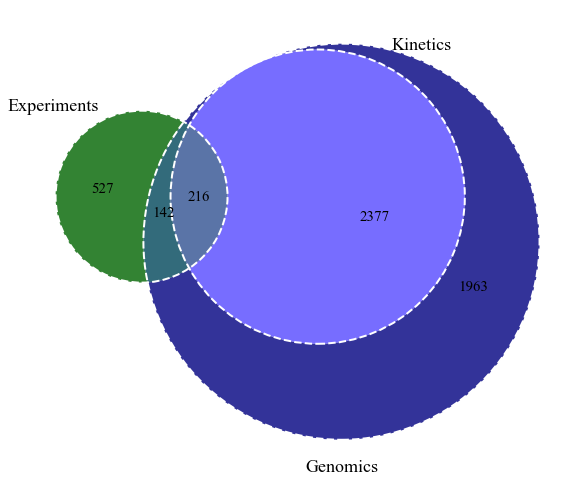

In [52]:
plt.figure(figsize = (10, 10))
venn3([set(list_exp), set(list_kinetics), set(list_genomics)], ('Experiments', 'Kinetics', 'Genomics'),
      set_colors=('darkgreen', 'mediumslateblue', 'navy'),
      alpha=0.8);
venn3_circles([set(list_exp), set(list_kinetics), set(list_genomics)], linestyle='dashed',  color='w');
plt.savefig('venndiagramALL.svg', dpi=600, bbox_inches = 'tight')

In [14]:
print('All compounds', bitdf.shape[1])
print('Experiments', len(list_exp))
print('Kinetics', len(list_kinetics))
print('Genomics', len(list_genomics))

print('Experiments + Kinetics', len(set(list_exp)|set(list_kinetics)) )
print('Experiments + Genomics', len(set(list_exp)|set(list_genomics)) )

All compounds 12662
Experiments 885
Kinetics 2593
Genomics 4698
Experiments + Kinetics 3262
Experiments + Genomics 5225


# Hypergeometric Distribution

In [15]:
from scipy.stats import hypergeom

In [21]:
#genomics
hypergeom.sf(len(set(list_exp)&set(list_genomics))-1, bitdf.shape[1], len(set(list_exp)), len(set(list_genomics)))

0.01813546136714512

In [23]:
#kinetics
hypergeom.sf(len(set(list_exp)&set(list_kinetics))-1, bitdf.shape[1], len(set(list_exp)), len(set(list_kinetics)))

0.001820292109121772

In [24]:
np.random.choice(list_genomics, len(list_kinetics), replace=False)

array(['XFFQVRFGLSBFON', 'XUCOLQITPSNBGF', 'WTWBUQJHJGUZCY', ...,
       'NLHMQOCIFRDSNU', 'IEENEQSEOWXDQK', 'HGHVCQZWRZWQKS'], dtype='<U14')

In [44]:
niter=10000
overlap_genomics_sample=[]
for ind in tqdm(range(niter)):
    samplegen=np.random.choice(list_genomics, len(list_kinetics), replace=False)
    overlap_genomics_sample.append(len(set(list_exp)&set(samplegen)))
    

    

overlap_genomics_sample=np.array(overlap_genomics_sample)
joblib.dump(overlap_genomics_sample, 'overlap_genomics_sample.pkl')

print("Probability Grater Equal", sum(overlap_genomics_sample>=(len(set(list_exp)&set(list_kinetics))))/niter)

100%|██████████| 10000/10000 [00:10<00:00, 914.46it/s]

Probability Grater Equal 0.0258


In [35]:
np.mean(overlap_genomics_sample)

197.5289

In [36]:
np.std(overlap_genomics_sample)

9.058938391997154

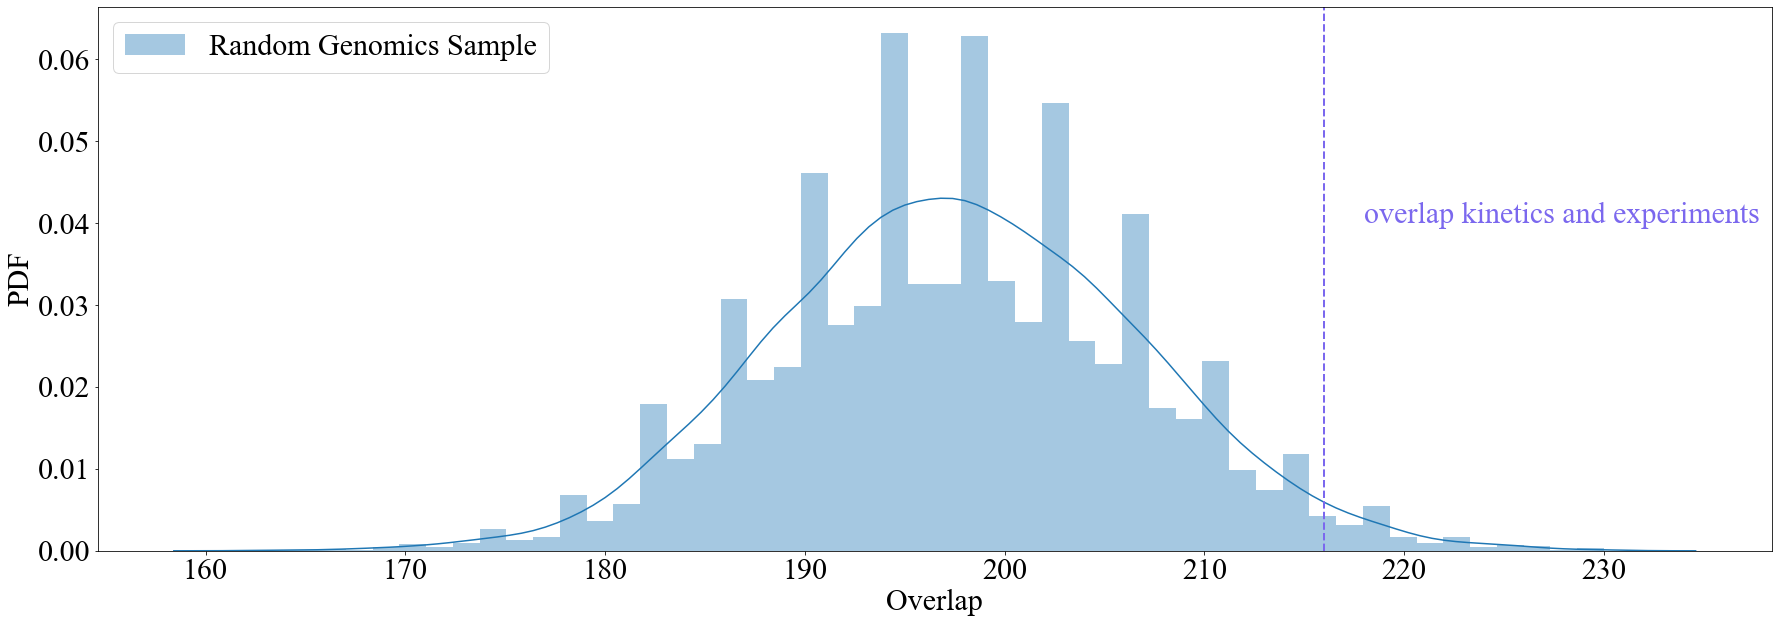

In [45]:
plt.figure(figsize = (30, 10))
ax1=sns.distplot(overlap_genomics_sample, label='Random Genomics Sample')
plt.legend(prop={'size': 30})
plt.xlabel('Overlap', fontsize=30)
plt.ylabel('PDF', fontsize=30);



ax1.axvline(len(set(list_exp)&set(list_kinetics)), color='mediumslateblue', linestyle='dashed', linewidth=2)
ax1.text(len(set(list_exp)&set(list_kinetics))+2,0.04,'overlap kinetics and experiments', color='mediumslateblue', fontsize=30);

plt.setp(ax1.get_xticklabels(), Fontsize=30)
plt.setp(ax1.get_yticklabels(), Fontsize=30);
#plt.savefig('kinetics.svg', dpi=600, bbox_inches = 'tight')

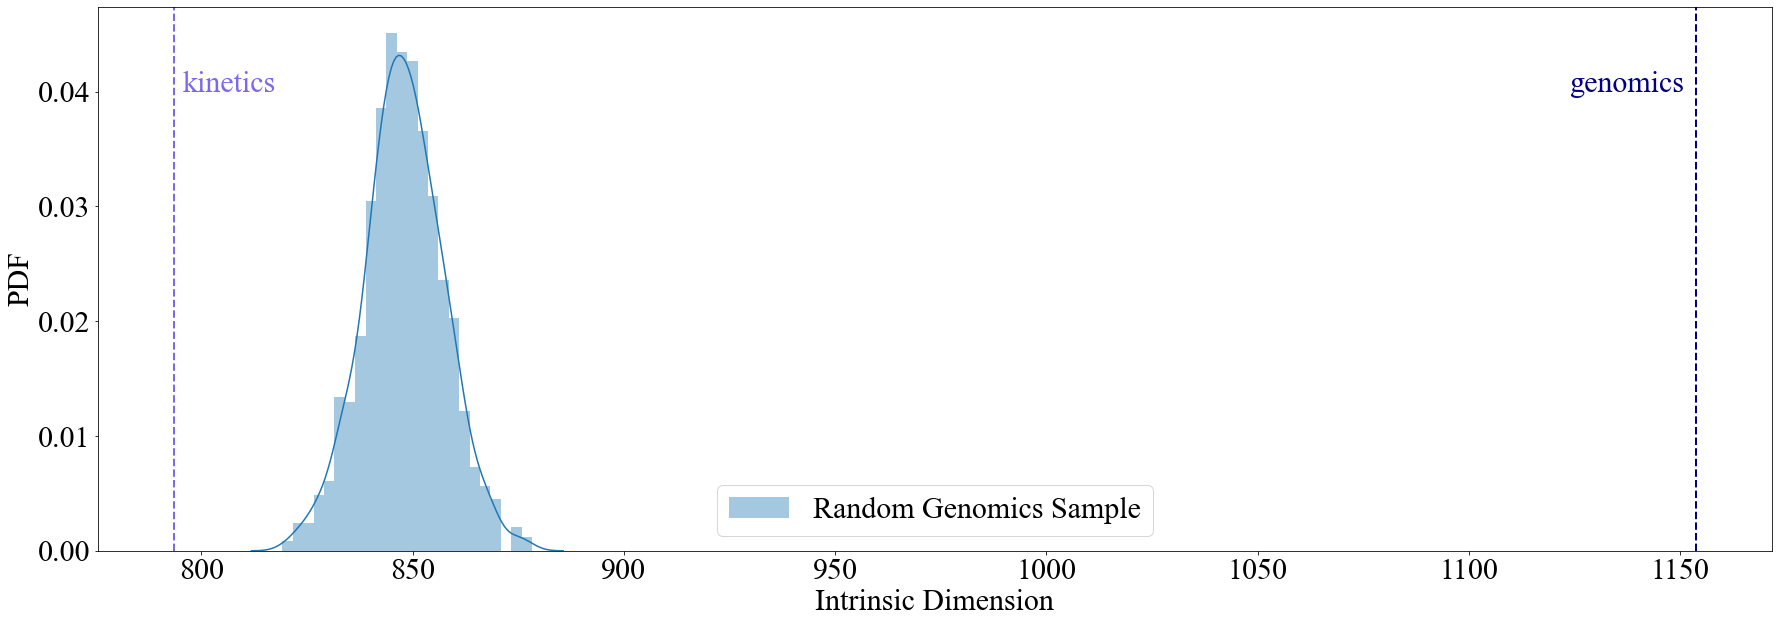

In [5]:
plt.figure(figsize = (30, 10))
ax1=sns.distplot(ID_genomics_sample, label='Random Genomics Sample')
plt.legend(prop={'size': 30})
plt.xlabel('Intrinsic Dimension', fontsize=30)
plt.ylabel('PDF', fontsize=30);

ax1.axvline(ID_all_genomics, color='navy', linestyle='dashed', linewidth=2)
ax1.text(ID_all_genomics-30,0.04,'genomics', color='navy', fontsize=30)

ax1.axvline(ID_all_kinetics, color='mediumslateblue', linestyle='dashed', linewidth=2)
ax1.text(ID_all_kinetics+2,0.04,'kinetics', color='mediumslateblue', fontsize=30);

plt.setp(ax1.get_xticklabels(), Fontsize=30)
plt.setp(ax1.get_yticklabels(), Fontsize=30);
#plt.savefig('kinetics.svg', dpi=600, bbox_inches = 'tight')

In [6]:
np.mean(ID_genomics_sample)

848.0077870647567

In [7]:
np.std(ID_genomics_sample)

9.44328787196432

In [8]:
ID_all_kinetics

793.4986612652997

In [9]:
ID_all_genomics

1153.6117636943447

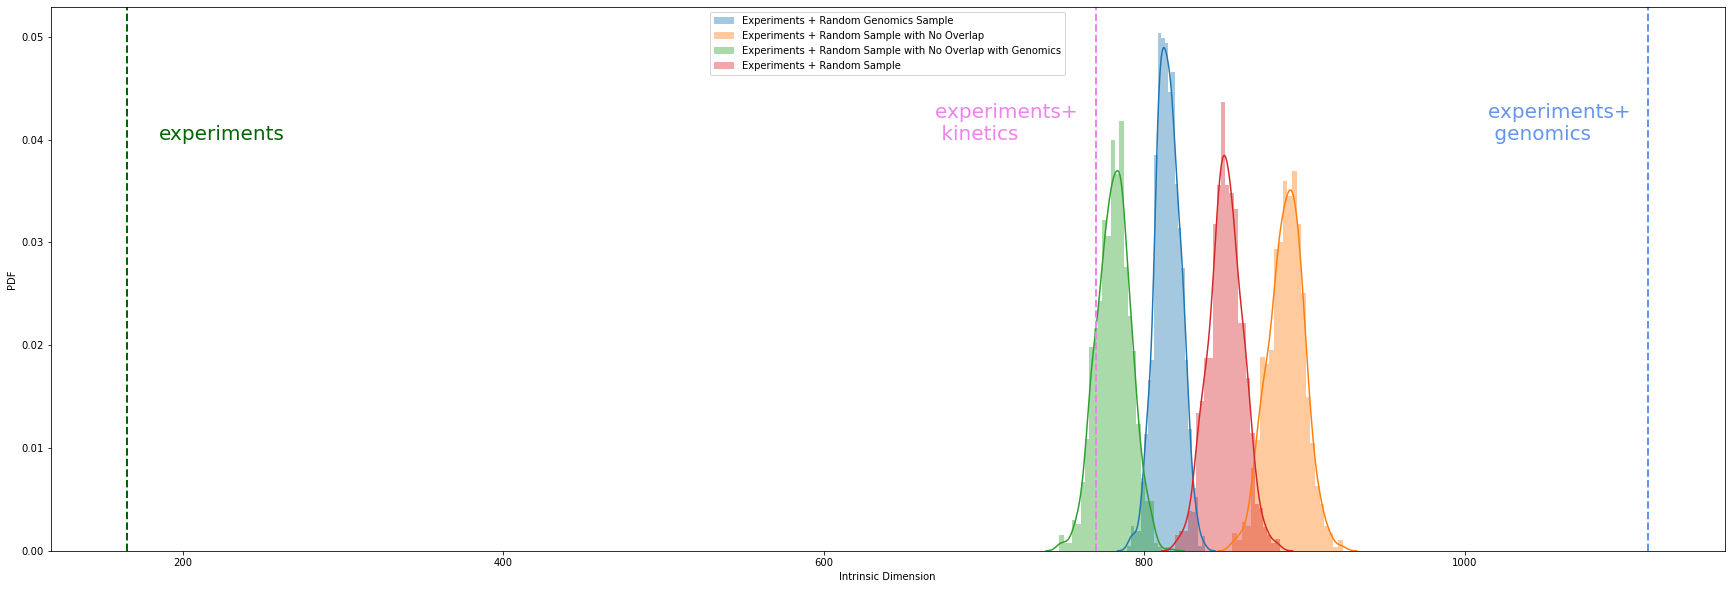

In [24]:
plt.figure(figsize = (30, 10))
ax1=sns.distplot(ID_addition2exp_sample, label='Experiments + Random Genomics Sample')
sns.distplot(ID_additionNOTexp_sample, label='Experiments + Random Sample with No Overlap', ax=ax1)
sns.distplot(ID_additionNOTgen_sample, label='Experiments + Random Sample with No Overlap with Genomics', ax=ax1)
sns.distplot(ID_addition_random_sample, label='Experiments + Random Sample', ax=ax1)

    
plt.legend()
plt.xlabel('Intrinsic Dimension')
plt.ylabel('PDF');
#plt.title('Morgan Fingerprint 8192 bits, Radius 3')

#plt.figure(figsize = figsize)
#ax1=sns.distplot(df['Prevalence %'], kde=False)
#ax1.axvline(ID_all_genomics, color='navy', linestyle='dashed', linewidth=2)
#ax1.text(ID_all_genomics+0.001,15,'genomics', color='navy', fontsize=20)

#ax1.axvline(ID_all_kinetics, color='mediumslateblue', linestyle='dashed', linewidth=2)
#ax1.text(ID_all_kinetics+0.001,15,'kinetics', color='mediumslateblue', fontsize=20)

ax1.axvline(ID_all_experiments, color='darkgreen', linestyle='dashed', linewidth=2)
ax1.text(ID_all_experiments+20,0.04,'experiments', color='darkgreen', fontsize=20)

ax1.axvline(ID_all_kinetics_experiments, color='violet', linestyle='dashed', linewidth=2)
ax1.text(ID_all_kinetics_experiments-100, 0.04,'experiments+ \n kinetics', color='violet', fontsize=20)

ax1.axvline(ID_all_genomics_experiments, color='cornflowerblue', linestyle='dashed', linewidth=2)
ax1.text(ID_all_genomics_experiments-100,0.04,'experiments+ \n genomics', color='cornflowerblue', fontsize=20);

#ax1.axvline(ID_alldb, color='darkred', linestyle='dashed', linewidth=2)
#ax1.text(ID_alldb+0.001,15,'all', color='darkred', fontsize=20);

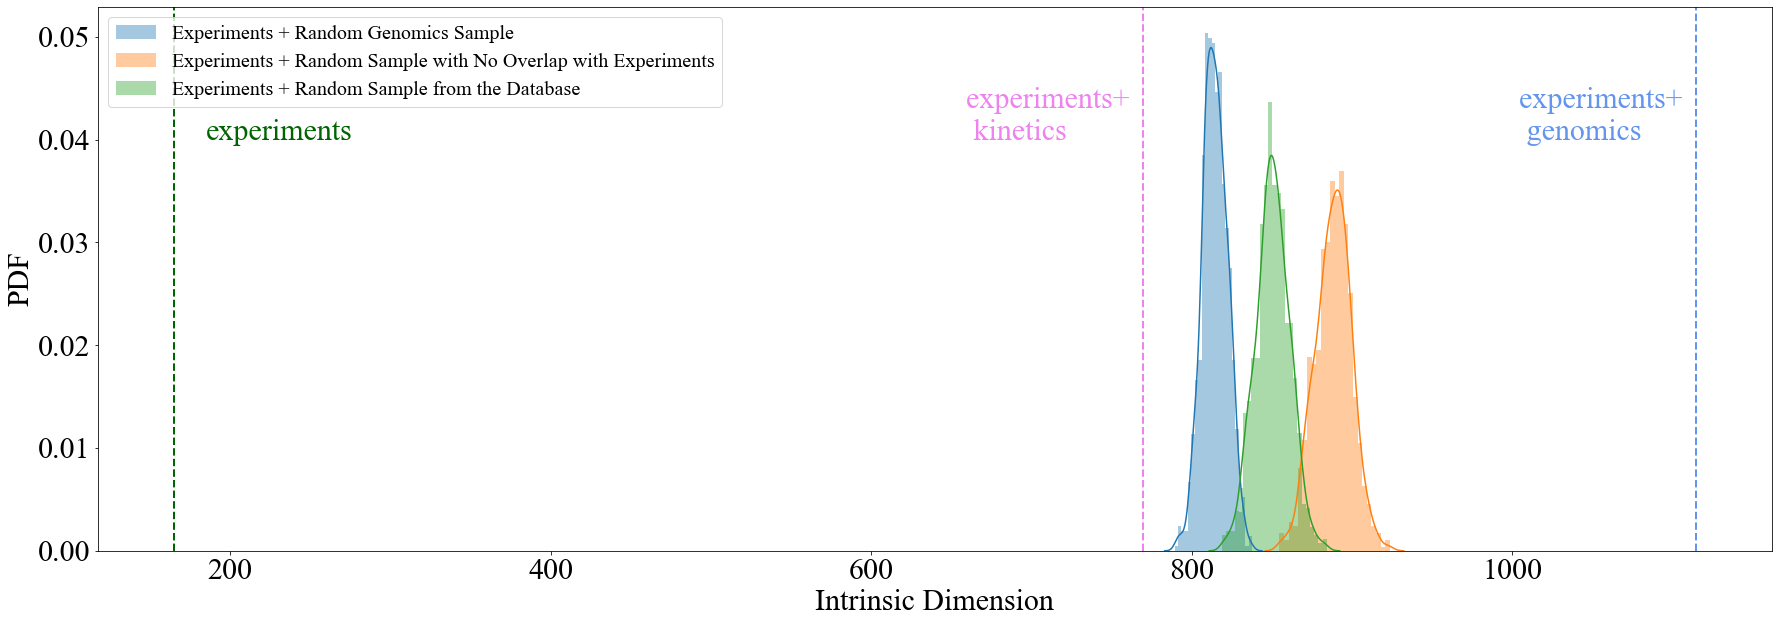

In [50]:
plt.figure(figsize = (30, 10))
ax1=sns.distplot(ID_addition2exp_sample, label='Experiments + Random Genomics Sample')
sns.distplot(ID_additionNOTexp_sample, label='Experiments + Random Sample with No Overlap with Experiments', ax=ax1)
sns.distplot(ID_addition_random_sample, label='Experiments + Random Sample from the Database', ax=ax1)

    
plt.legend(prop={'size': 20})
plt.xlabel('Intrinsic Dimension', fontsize=30)
plt.ylabel('PDF', fontsize=30)

ax1.axvline(ID_all_experiments, color='darkgreen', linestyle='dashed', linewidth=2)
ax1.text(ID_all_experiments+20,0.04,'experiments', color='darkgreen', fontsize=30)

ax1.axvline(ID_all_kinetics_experiments, color='violet', linestyle='dashed', linewidth=2)
ax1.text(ID_all_kinetics_experiments-110, 0.04,'experiments+ \n kinetics', color='violet', fontsize=30)

ax1.axvline(ID_all_genomics_experiments, color='cornflowerblue', linestyle='dashed', linewidth=2)
ax1.text(ID_all_genomics_experiments-110,0.04,'experiments+ \n genomics', color='cornflowerblue', fontsize=30);
plt.setp(ax1.get_xticklabels(), Fontsize=30)
plt.setp(ax1.get_yticklabels(), Fontsize=30);
plt.savefig('experiments.svg', dpi=600, bbox_inches = 'tight')

In [3]:
(ID_only_kinetics, ID_genomics_sample_no)=joblib.load('sim_ID_only_kinetics_ID_genomics_sample_no.pkl')
(ID_all_kinetics_experiments_no_overlap, ID_addition2exp_sample_no)=joblib.load('sim_ID_addition2exp_no_overlap.pkl')


In [5]:
print(ID_only_kinetics)
print(ID_all_kinetics_experiments_no_overlap)

751.7434743657559
769.5336516546861


# run overlap: done
# also hypergeometric distribution: done
# remove chemical in overlap and evalute the similarity
# sample the same number from genomics (with no overlap) and check the similarity


kinetics - overlap
genomics - overlap